In [1]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


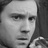

In [3]:
# loading a sample image
sample_image = Image.open("/content/gdrive/MyDrive/images/train/angry/0.jpg")
sample_image

In [4]:
np.array(sample_image).shape

(48, 48)

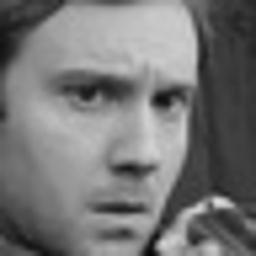

In [5]:
sample_image = sample_image.resize([256,256])
sample_image

In [6]:
np.array(sample_image).shape

(256, 256)

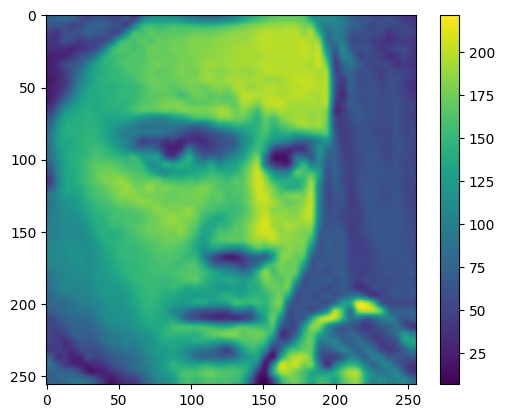

In [7]:
plt.imshow(np.array(sample_image))
plt.colorbar()

## Extract only face from images

In [8]:
from google.colab.patches import cv2_imshow

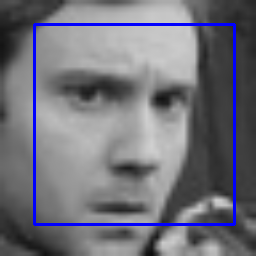

In [9]:
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/MyDrive/images/train/angry/0.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)

In [10]:
cropped_img.shape

(256, 256, 3)

In [11]:
cropped_img = cropped_img.sum(axis=2)

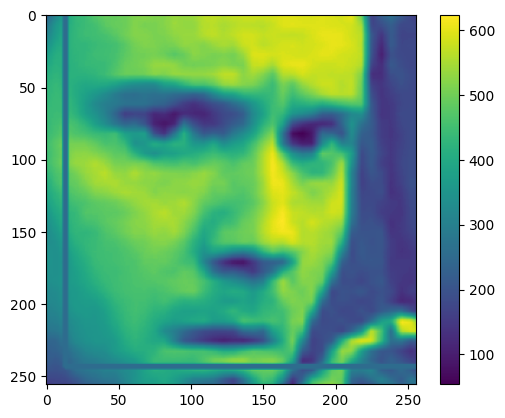

In [12]:
plt.imshow(cropped_img)
plt.colorbar()

## Load Data and Extract only Face

In [13]:
import cv2

In [14]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [15]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

In [16]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/MyDrive/images/train', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [23]:
for i,img in enumerate(x_data):
  if len(img.shape) == 3:
    x_data[i] = img.sum(axis=2)

(23064, 200, 200, 1) (23064, 7)
(5767, 200, 200, 1) (5767, 7)


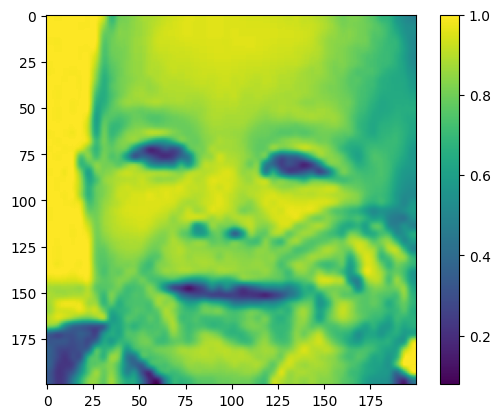

In [17]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

## Base VGG16

In [18]:
VGG16_model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layers:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),

    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [19]:
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                    

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [21]:
VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [22]:
n_epoch = 30
hist = VGG16_model.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
721/721 [==============================] - 51s 48ms/step - loss: 1.8034 - categorical_accuracy: 0.2545 - val_loss: 1.7144 - val_categorical_accuracy: 0.2937
Epoch 2/30
721/721 [==============================] - 30s 42ms/step - loss: 1.5517 - categorical_accuracy: 0.3897 - val_loss: 1.4210 - val_categorical_accuracy: 0.4526
Epoch 3/30
721/721 [==============================] - 30s 42ms/step - loss: 1.3061 - categorical_accuracy: 0.4972 - val_loss: 1.2152 - val_categorical_accuracy: 0.5322
Epoch 4/30
721/721 [==============================] - 31s 43ms/step - loss: 1.1050 - categorical_accuracy: 0.5822 - val_loss: 1.1516 - val_categorical_accuracy: 0.5667
Epoch 5/30
721/721 [==============================] - 31s 43ms/step - loss: 0.8746 - categorical_accuracy: 0.6753 - val_loss: 1.1383 - val_categorical_accuracy: 0.5785
Epoch 6/30
721/721 [==============================] - 30s 42ms/step - loss: 0.5227 - categorical_accuracy: 0.8136 - val_loss: 1.4502 - val_categorical_accuracy:

In [26]:
VGG16_model.save('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model')

In [24]:
n_epoch = 8

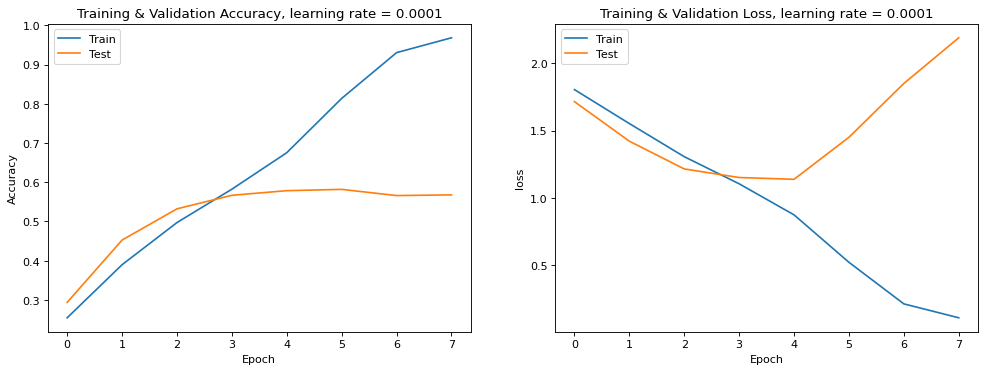

In [25]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

Seems overfitted. Next step is try to reduce overfitting.

## Batch Normalisation and Drop Out

In [29]:
VGG16_model_bn = tf.keras.models.Sequential([
    
    # Input layer
    tf.keras.layers.Input(x_train[0].shape),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3, padding='same',activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # convolutional layer with batch normalisation:
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=512,kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Max pooling layer:
    tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),

    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    # Batch Normalisation layer:
    tf.keras.layers.BatchNormalization(),


    # output layer:
    tf.keras.layers.Dense(7, activation='softmax')
])

In [30]:
VGG16_model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                     loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                     metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [32]:
n_epoch = 30
hist = VGG16_model_bn.fit(x_train, y_train,
              epochs=n_epoch,
              batch_size=32,
              validation_data=(x_val, y_val),
              callbacks=[callback])

Epoch 1/30
721/721 [==============================] - 52s 60ms/step - loss: 2.0593 - categorical_accuracy: 0.2672 - val_loss: 1.6110 - val_categorical_accuracy: 0.3843
Epoch 2/30
721/721 [==============================] - 42s 58ms/step - loss: 1.6400 - categorical_accuracy: 0.3974 - val_loss: 1.4619 - val_categorical_accuracy: 0.4377
Epoch 3/30
721/721 [==============================] - 41s 57ms/step - loss: 1.4292 - categorical_accuracy: 0.4633 - val_loss: 1.2366 - val_categorical_accuracy: 0.5233
Epoch 4/30
721/721 [==============================] - 41s 57ms/step - loss: 1.2628 - categorical_accuracy: 0.5246 - val_loss: 1.1905 - val_categorical_accuracy: 0.5455
Epoch 5/30
721/721 [==============================] - 41s 57ms/step - loss: 1.1416 - categorical_accuracy: 0.5745 - val_loss: 1.1221 - val_categorical_accuracy: 0.5686
Epoch 6/30
721/721 [==============================] - 42s 58ms/step - loss: 1.0494 - categorical_accuracy: 0.6105 - val_loss: 1.1602 - val_categorical_accuracy:

In [35]:
n_epoch=11

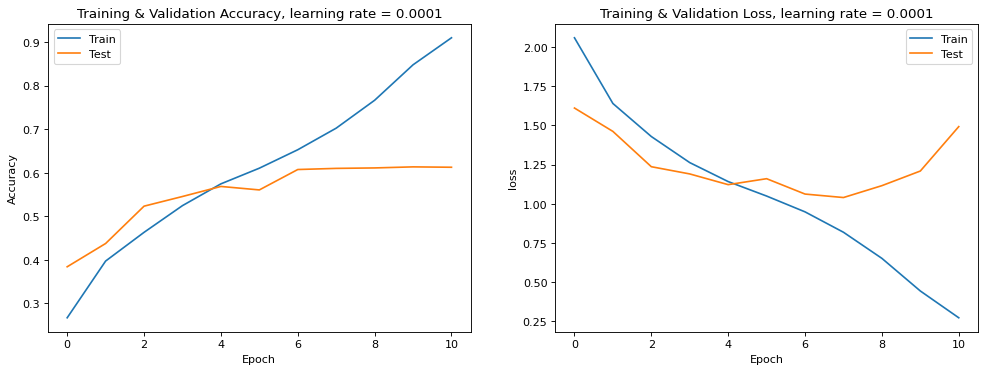

In [36]:
plt.figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(np.arange(n_epoch),hist.history.get('categorical_accuracy'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_categorical_accuracy'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.title("Training & Validation Accuracy, learning rate = 0.0001")

plt.subplot(1, 2, 2) # index 2
plt.plot(np.arange(n_epoch),hist.history.get('loss'), label="Train")
plt.plot(np.arange(n_epoch),hist.history.get('val_loss'), label="Test")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend(loc='best')
plt.title("Training & Validation Loss, learning rate = 0.0001")
plt.show()

In [38]:
VGG16_model_bn.save('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning/VGG16_model_bn')